# RDKit interface

In this tutorial we will demonstrate how molli's molecule objects can be efficiently converted into RDKit objects.

Note: Openbabel is not natively installed within Molli, but it can be added through conda using the line:
`pip install rdkit` or `conda install rdkit`

In [1]:
import molli as ml
from rdkit import Chem
from molli.external import _rdkit as mrd
import numpy as np

The creation of an RDKit object creates a dictionary where the `ml_mol` object can function as a key to the `rd_mol` so they will always be linked.

{Molecule(name='dendrobine', formula='C16 H25 N1 O2'): <rdkit.Chem.PropertyMol.PropertyMol object at 0x7f2a64533240>}


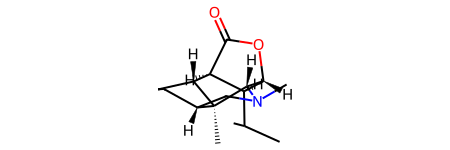

In [2]:
with open(ml.files.dendrobine_mol2) as f:
    ml_mol = ml.Molecule.load_mol2(f)

ml_rd_dict = mrd.create_rdkit_mol(ml_mol, removeHs=True)
print(f'{ml_rd_dict}')

rd_mol = ml_rd_dict[ml_mol]
rd_mol

In the above example, all hydrogens were removed from the `rd_mol`, DESPITE THE IMAGE DEPICTING IT WITH HYDROGENS. The element labels are not a 1:1 mapping between `ml_mol` and `rd_mol`. This can be shown by printing the symbols of the atoms in both objects.

If the `ml_mol` is reduced to only heavy atoms, it maintains the same order as the `rd_mol`.

In [3]:
rd_labels = [x.GetSymbol() for x in rd_mol.GetAtoms()]
ml_labels = [x.label for x in ml_mol.atoms]

ml_heavy_atoms = [ml_mol.get_atom(x) for x in ml_mol.heavy.parent_atom_indices]
ml_heavy_labels = [x.label for x in ml_heavy_atoms]

print(f'All Molli Element Labels:\n{ml_labels}')
print(f'All RDKit Element Labels:\n{rd_labels}')
print(f'Molli Heavy Element Labels Only:\n{ml_heavy_labels}')

All Molli Element Labels:
['N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
All RDKit Element Labels:
['N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C']
Molli Heavy Element Labels Only:
['N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C']


The creation of the `create_rdkit_mol` function by default maintains the hydrogens associated with the structure. This is for the purpose of mapping the  indexes of atoms from the `rd_mol` back to the full 3D structure in `ml_mol`. 

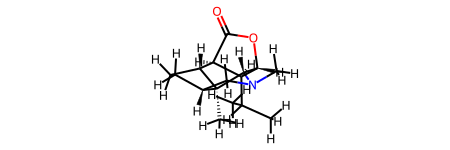

In [4]:
with open(ml.files.dendrobine_mol2) as f:
    ml_mol = ml.Molecule.load_mol2(f)

ml_rd_dict = mrd.create_rdkit_mol(ml_mol)


rd_mol = ml_rd_dict[ml_mol]
print(rd_mol)
rd_mol

In this example, since the Hydrogens were not removed, the order of element labels has not been changed between the `ml_mol` and `rd_mol` It is recommended that you work with `rd_mol` without removing the hydrogens to allow for direct mapping.

In [5]:
rd_atoms = [x.GetSymbol() for x in rd_mol.GetAtoms()]
ml_elements = [x.label for x in ml_mol.atoms]
print(f'All Molli Element Labels:\n{ml_elements}')
print(f'All RDKit Element Labels:\n{rd_atoms}')

All Molli Element Labels:
['N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
All RDKit Element Labels:
['N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


A common method utilized within RDKit is "canonicalization" of SMILES strings, which reorders the order of atoms in the SMILES string such that any permutation of a SMILES input will always be represented in the same way.

This allows direct comparison of structures solely by strings, which is a much less intensive operation than comparing individual atom and bond properties between molecule objects.

In [6]:
#Bromobenzene 1
smi1 = 'c1ccccc1(Br)'
rdmol1 = Chem.MolFromSmiles(smi1)
can_smi1 = Chem.MolToSmiles(rdmol1, canonical=True)

#Bromobenzene 2
smi2 = 'c1ccc(Br)cc1'
rdmol2 = Chem.MolFromSmiles(smi2)
can_smi2 = Chem.MolToSmiles(rdmol2, canonical=True)

print(f'SMILES 1\nOriginal SMILES:{smi1}\nCanonical SMILES:{can_smi1}\n')
print(f'SMILES 2\nOriginal SMILES:{smi2}\nCanonical SMILES:{can_smi2}')

SMILES 1
Original SMILES:c1ccccc1(Br)
Canonical SMILES:Brc1ccccc1

SMILES 2
Original SMILES:c1ccc(Br)cc1
Canonical SMILES:Brc1ccccc1


Molli has an implementation that can take the `rd_mol` and `ml_mol` and map the two structures to a canonicalized version of the `rd_mol` 

This will not change the actual coordinates of the `ml_mol` but rather just the order of the coordinates. This will allow for integration into RDKit workflows without accidental loss of information.

Note: The current implementation will modify the `ml_mol` atom, bond, and coordinate order in place.

In [7]:
can_rdmol, atom_reorder, bond_reorder = mrd.can_mol_order(rd_mol)

can_ml_rd_dict = mrd.reorder_molecule(ml_mol, can_rdmol, atom_reorder, bond_reorder)

new_rd_labels = [x.GetSymbol() for x in can_rdmol.GetAtoms()]
new_ml_labels = [x.label for x in ml_mol.atoms]
print(f'Molli Element Labels:\n{new_rd_labels}')
print(f'RDKit Element Labels:\n{new_ml_labels}')

Molli Element Labels:
['H', 'C', 'H', 'H', 'N', 'C', 'H', 'H', 'C', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'O', 'O', 'C', 'H', 'C', 'H', 'C', 'C', 'H', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'H', 'H', 'H']
RDKit Element Labels:
['H', 'C', 'H', 'H', 'N', 'C', 'H', 'H', 'C', 'H', 'C', 'H', 'H', 'C', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'O', 'O', 'C', 'H', 'C', 'H', 'C', 'C', 'H', 'H', 'H', 'C', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'C', 'H', 'H', 'H']


There is also an implementation of an interface with RDKit's `rdQueries` module that allows for quick querying of atom properties. 

The <span style="color: green">rdkit_atom_filter</span> class offers simple quick querying of rdkit mols, returning an array of <span style="color: #1750e8">True</span> or <span style="color: #1750e8">False</span> based on the position of atoms in an ordered array.

An example use case is given below:

In [8]:
#(E)-β-Bromostyrene canonicalization
rdmol = Chem.MolFromSmiles('Br\C=C\c1ccccc1')
rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(rdmol, canonical=True))

ac_rdmol = mrd.rdkit_atom_filter(rdmol)

aromatic_bool = ac_rdmol.aromatic_type()
print(Chem.MolToSmiles(rdmol))
aromatic_bool

Br/C=C/c1ccccc1


array([False, False, False,  True,  True,  True,  True,  True,  True])

Within the SMILES string, the property of atoms being `aromatic` is only <span style="color: #1750e8">True</span> for the atoms associated with the benzene ring, so the resulting array will be <span style="color: #1750e8">False</span> for the first 3 atoms, while the 6 atoms in that array will be <span style="color: #1750e8">True</span>. This logic can undergo basic boolean operations to allow for quick screening of certain properties

In [9]:
alkene_bool = ac_rdmol.sp2_type() & ~ac_rdmol.aromatic_type()
print(Chem.MolToSmiles(rdmol))
alkene_bool

Br/C=C/c1ccccc1


array([False,  True,  True, False, False, False, False, False, False])

This can also be extended to allow Smarts querying and to allow more general purpose binning of atoms. An example is shown below with how 4 different rdkit mol objects could be binned into different lists just by querying molecules that may contain either a `Cl`, `Br`, or `I`.

In [10]:
#(1-chloro-3-[(E)-2-chloroethenyl]benzene canonicalization
di_cl_rdmol = Chem.MolFromSmiles('Cl\C=C\c1cccc(Cl)c1')
di_cl_rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(di_cl_rdmol, canonical=True))
di_cl_rdmol.SetProp("_Name", '2cl_mol')

#(E)-β-Bromostyrene canonicalization
br_rdmol = Chem.MolFromSmiles('Br\C=C\c1ccccc1')
br_rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(br_rdmol, canonical=True))
br_rdmol.SetProp("_Name", 'br_mol')

#(E)-β-Iodostyrene canonicalization
i_rdmol = Chem.MolFromSmiles('I\C=C\c1ccccc1')
i_rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(i_rdmol, canonical=True))
i_rdmol.SetProp("_Name", 'i_rdmol')

#(E)-β-Methylstyrene canonicalization
c_rdmol = Chem.MolFromSmiles('C\C=C\c1ccccc1')
c_rdmol = Chem.MolFromSmiles(Chem.MolToSmiles(c_rdmol, canonical=True))
c_rdmol.SetProp("_Name", 'c_rdmol')

rdmol_list = [di_cl_rdmol, br_rdmol, i_rdmol, c_rdmol]

no_halogen_mols = list()
single_halogen_mols = list()
multi_halogen_mols = list()

for rdmol in rdmol_list:

    ac_rdmol = mrd.rdkit_atom_filter(rdmol)

    halogen_bool = ac_rdmol.smarts_query('[Cl,Br,I]')

    true_count = np.count_nonzero(halogen_bool)

    if true_count > 1:
        multi_halogen_mols.append(rdmol.GetProp("_Name"))

    elif true_count == 1:
        single_halogen_mols.append(rdmol.GetProp("_Name"))
    
    else:
        no_halogen_mols.append(rdmol.GetProp("_Name"))

print(f'Multiple Halogen Mols:\n{multi_halogen_mols}\n')
print(f'Single Halogen Mols:\n{single_halogen_mols}\n')
print(f'No Halogen Mols\n{no_halogen_mols}\n')


Multiple Halogen Mols:
['2cl_mol']

Single Halogen Mols:
['br_mol', 'i_rdmol']

No Halogen Mols
['c_rdmol']

